# Создание нейронной сети для распознавания растений и деревьев на изображениях.

## Датасет

Датасет состоит из 15 папок, каждая из которых содержит изображения. Каждый файл в отдельной папке относится к одному виду растений. Эти изображения будут использованы для обучения и оценки модели классификации изображений.

### Обзор данных
Давайте определим такие характеристики изображений датасета, как:

- Размер
- Число каналов
- Количество изображений по классам
- Общее количество изображений

#### Импортируем библиотеки

In [3]:
import os
from matplotlib.image import imread
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

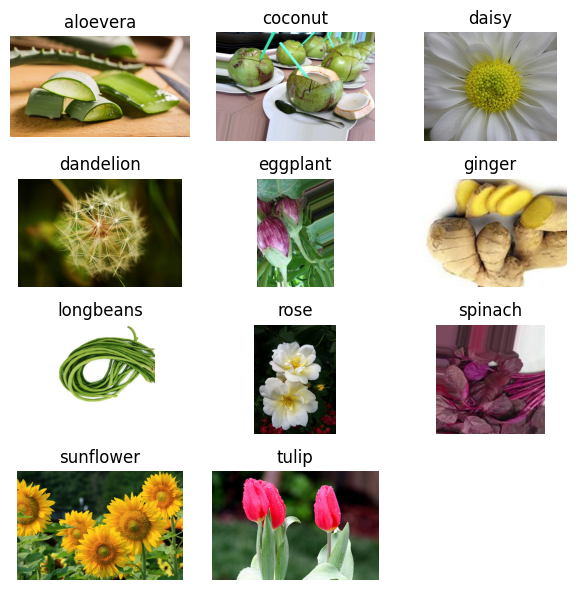

In [4]:
path = 'dataset'

# у нас 11 разных типов растений и деревьев
os.listdir(path)

fig = plt.figure(figsize=(6,6)) 
rows = 4
columns = 3

for i, image_filename in enumerate(os.listdir(path)):

    first_img_path = os.listdir(os.path.join(path, image_filename))[0]
    first_image = imread(os.path.join(path, image_filename, first_img_path))
    fig.add_subplot(rows, columns, i+1) 
    plt.axis('off') 
    plt.imshow(first_image)
    plt.title('{}'.format(image_filename, fontsize=10))

plt.tight_layout()
plt.show()

**Давайте вычислим средние размерности этих изображений.**

In [5]:
dim1 = []    # ширина
dim2 = []    # высота
channels = []  # каналы

for i, image_filename in enumerate(os.listdir(path)):
    
    subfolders_path = os.path.join(path, image_filename)
    for image_path in os.listdir(subfolders_path):
        image = imread(os.path.join(subfolders_path,image_path))

        # на случай одноканальных изображений
        if len(image.shape) < 3:
            image = image.reshape(image.shape + (1,))
            
        d1,d2,color = image.shape
        dim1.append(d1)
        dim2.append(d2)
        channels.append(color)

Отобразим результат на графике:

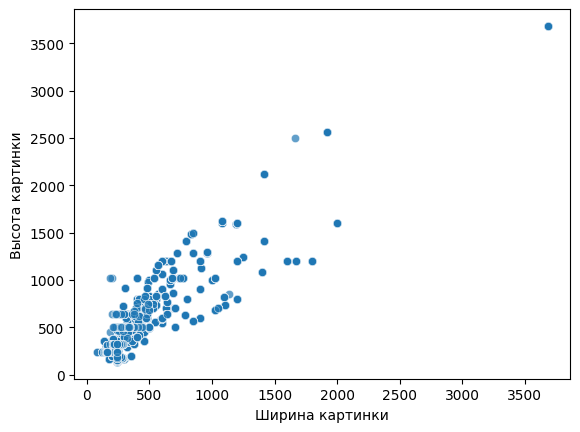

In [6]:
sns.scatterplot(x=dim1, y=dim2, alpha = 0.7)
plt.xlabel('Ширина картинки')
plt.ylabel('Высота картинки');

Как видно из графика:
- Ширина картинок достигает 3500+ пикселей.
- Высота картинок достигает 3500+ пикселей.

Однако в большинстве ширина и высота изображений не превышает 1000 пикселей.

In [7]:
# средняя ширина
mean_width = int(np.mean(dim1))
print(mean_width)
# средняя высота
mean_height = int(np.mean(dim2))
print(mean_height)
# кол-во найденных каналов
print(np.unique(channels))

315
416
[3]


Кол-во найденных каналов изображений датасета - [3], а это значит, что пиксели всех изображений представлены в виде R, G и B (Red, Green, Blue). 
При обучении CNN важно, чтобы входные изображения имели одинаковый размер, поэтому мы будем изменять его до (315, 416, 3).

In [8]:
input_shape =  (mean_width, mean_height, 3)

**Посчитаем количество изображений:**

In [9]:
all_data_sum=0
images_count_dict = {}
for image_filename in os.listdir(path):

    folder_path = os.path.join(path, image_filename)
    images_count = len(os.listdir(folder_path))
    images_count_dict[image_filename] = images_count
    all_data_sum += images_count
    print(f"{image_filename}: {images_count}")

print(f"\nВсего: {all_data_sum} картинок")

aloevera: 799
coconut: 799
daisy: 764
dandelion: 800
eggplant: 799
ginger: 799
longbeans: 799
rose: 784
spinach: 799
sunflower: 733
tulip: 800

Всего: 8675 картинок


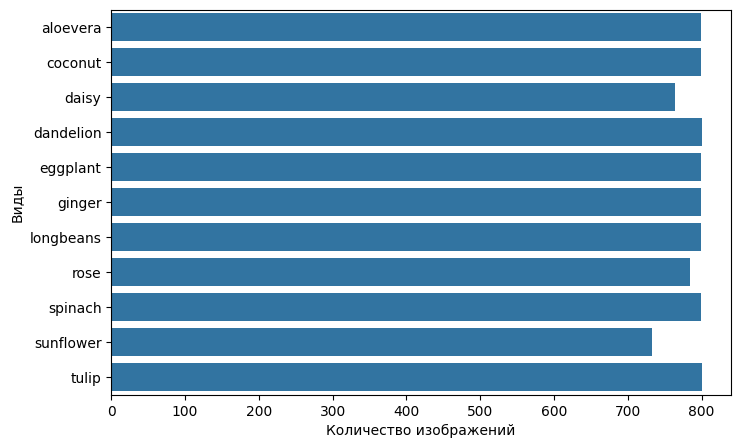

In [10]:
data = list(images_count_dict.items())
num_classes = len(data)

# Create a bar plot using Seaborn
plt.figure(figsize=(8, 5))
sns.barplot(y=[x[0] for x in data], x=[x[1] for x in data])
plt.ylabel('Виды')
plt.xlabel('Количество изображений');

## Нейронная сеть

- Выбираем архитектуру
    - Сверточный модуль:
        - Сверточный слой, выделяющий 32 признака по фильтрам размерами 3 и глубиной 3 (RGB каналы изображений для разделения цветов) с функцией активации `ReLU`
        - Слой макс-пуллинга, сжимающий карты первичных признаков в 2 раза
        - Сверточный слой, выделяющий 64 признака по фильтрам размерами 3 и глубиной 3 с активацией `ReLU`
        - Слой макс-пуллинга, сжимающий карты вторичных признаков в 2 раза
        - Преобразование карт признаков в единый массив размерами 64
    - Полносвязный модуль:
        - Скрытый полносвязный слой из 64 нейронов с функцией активации ReLU со значением Dropout 0.5
        - Выходной полносвязный слой из 15 нейронов (количество классов) с функцией активации `softmax` со значением Dropout 0.5

- Импортируем библиотеку `tensorflow` для создания нейронной сети

In [11]:
import tensorflow as tf

- Составляем модель нейронной сети по описанной выше архитектуре:

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')])

- Компилируем модель с оптимизатором `Adam` и рассчетой потерь по `категориальной кросс-энтропии`:

In [13]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

- Загрузим тренировочные картинки из папки 'dataset':

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(mean_width, mean_height),
    batch_size=32)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 8675 files belonging to 11 classes.
Using 6940 files for training.


Обучим нашу нейросеть со 100 эпохами:

In [15]:
model.fit(train_ds, epochs=100)

Epoch 1/100
217/217 [==============================] - 27s 102ms/step - loss: 23.3109 - accuracy: 0.0964
Epoch 2/100
217/217 [==============================] - 18s 84ms/step - loss: 2.3990 - accuracy: 0.1029
Epoch 3/100
217/217 [==============================] - 18s 84ms/step - loss: 2.3899 - accuracy: 0.1128
Epoch 4/100
217/217 [==============================] - 18s 82ms/step - loss: 2.3790 - accuracy: 0.1160
Epoch 5/100
217/217 [==============================] - 18s 82ms/step - loss: 2.3747 - accuracy: 0.1187
Epoch 6/100
217/217 [==============================] - 18s 82ms/step - loss: 2.3518 - accuracy: 0.1353
Epoch 7/100
217/217 [==============================] - 33s 151ms/step - loss: 2.3460 - accuracy: 0.1372
Epoch 8/100
217/217 [==============================] - 18s 84ms/step - loss: 2.3222 - accuracy: 0.1512
Epoch 9/100
217/217 [==============================] - 18s 84ms/step - loss: 2.2983 - accuracy: 0.1614
Epoch 10/100
217/217 [==============================] - 18s 83ms/step 

- Сохраним веса модели для дальнейшего использования:

In [16]:
model.save('trees_and_plants.h5')

- Сделаем несколько тестовых предсказаний:

In [17]:
from PIL import Image
src_classes = os.listdir("dataset")

test_images = [
    Image.open('dataset/aloevera/aloevera5.jpg'),
    Image.open('dataset/dandelion/8475769_3dea463364_m.jpg'),
    Image.open('dataset/daisy/21652746_cc379e0eea_m.jpg'),
    Image.open('dataset/rose/118974357_0faa23cce9_n.jpg')
]

for img in test_images:
    image_array = np.array(img.resize((mean_height, mean_width)))
    preds = model.predict(np.expand_dims(image_array, axis=0))
    print(src_classes[np.argmax(preds)])

1/1 [==============================] - 0s 191ms/step
aloevera
1/1 [==============================] - 0s 12ms/step
dandelion
1/1 [==============================] - 0s 12ms/step
daisy
1/1 [==============================] - 0s 13ms/step
rose
